In [1]:
include("../Engine/Engine.jl")
using .Engine

using StatsBase, DataFrames
import PyPlot as plt
import Seaborn as sns

In [11]:
df = load_dataset(RandomDays)
df = no_partition(df)
df = trust_score(df)
f, _ = all_users()
df = f(df)

df = unique(df, :username)

plot_actor_wordcloud(df, save=true, filename="../../Figures/Datasets/Random_all_users/wordcloud.svg")

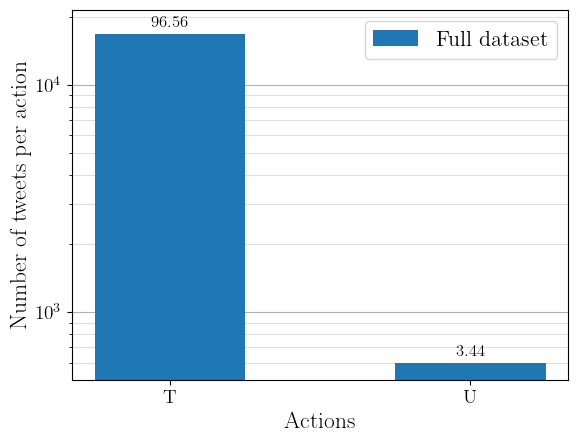

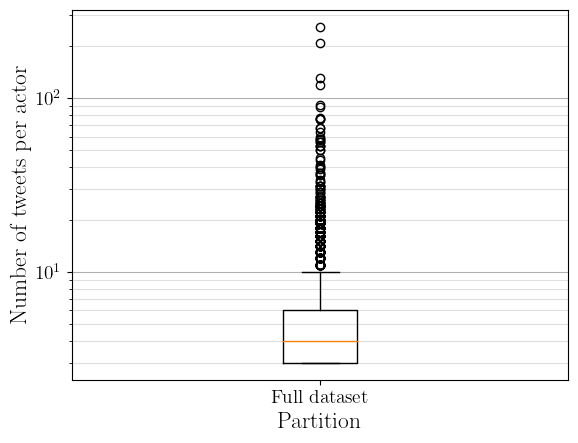

In [6]:
df = load_dataset(RandomDays)
df = no_partition(df)
df = trust_score(df)
f, _ = all_users()
df = f(df)


plot_action_frequency(df, save=true, filename="../../Figures/Datasets/Random_all_users/action_frequency.pdf");
plot_actor_frequency(df, save=true, filename="../../Figures/Datasets/Random_all_users/actor_frequency.pdf");

In [5]:
df = load_dataset(Skripal)
df = skripal_dates(df)
df = trust_score(df)
f, _ = IP_scores()

df1 = df[df.action .== "U", :]
df2 = df[df.action .== "T", :]

df1 = f(df1)
df2 = f(df2)


partitions = sort(unique(df.partition))
dfs_U = []
dfs_T = []

for partition in partitions
    useful1 = df1[df1.partition .== partition, :]
    useful1 = unique(useful1, :username)[:, ["username", "partition", "I_score", "P_score"]]
    useful1."I score_rank" = ordinalrank(useful1.I_score, rev=true)
    sort!(useful1, "I score_rank")
    push!(dfs_U, useful1)

    useful2 = df2[df2.partition .== partition, :]
    useful2 = unique(useful2, :username)[:, ["username", "partition", "I_score", "P_score"]]
    useful2."I score_rank" = ordinalrank(useful2.I_score, rev=true)
    sort!(useful2, "I score_rank")
    push!(dfs_T, useful2)
end

Any[]

In [11]:
dfs_U[3]

,username,partition,I_score,P_score,I score_rank
,String,String,Float64,Float64,Int64
1,CraigMurrayOrg,During campaign,0.213864,0.0,1
2,10DaysThatShook,During campaign,0.140714,2.05427e-78,2
3,NeilClark66,During campaign,0.0583348,0.00311221,3
4,RusEmbUSA,During campaign,0.0563711,0.00111249,4
5,OffGuardian0,During campaign,0.0446269,0.000296312,5
6,21WIRE,During campaign,0.0393887,0.00178915,6
7,tassagency_en,During campaign,0.0318397,0.0,7
8,Ian56789,During campaign,0.0301492,0.00190712,8
9,RT_com,During campaign,0.0273928,0.000156474,9


In [12]:
dfs_T[3]

,username,partition,I_score,P_score,I score_rank
,String,String,Float64,Float64,Int64
1,NeilClark66,During campaign,0.146037,0.00102892,1
2,haynesdeborah,During campaign,0.0803617,0.0,2
3,Billbrowder,During campaign,0.0592969,0.0,3
4,ShoebridgeC,During campaign,0.0348364,0.0,4
5,IscaSaboteur,During campaign,0.0278662,0.0,5
6,WarmongerHodges,During campaign,0.0261698,0.0,6
7,ChristopherJM,During campaign,0.0251291,0.00246542,7
8,MarkGaleotti,During campaign,0.0240805,0.0,8
9,nytopinion,During campaign,0.01752,0.0,9


In [ ]:
using ArgParse, StatsBase
import Random
Random.seed!(12)
# import PyPlot as plt
# using PyPlot: @L_str
# import Seaborn as sns

include("Engine/Engine.jl")
using .Engine

function draw_series(N, M = 150, min_ = 3, weights = nothing)
    if isnothing(weights)
        weights = AnalyticWeights([0.965, 0.03, 0.003, 0.001, 0.001])
    end

    sample_ = [sample(0:4, weights, M) for i = 1:N]
    for i = 1:N
        if sum(sample_[i]) < min_
            while sum(sample_[i]) < min_
                sample_[i] = sample(0:4, weights, M)
            end
        end
    end

    return sample_

end


args = parse_commandline()


N 10
N_redo_all = 5
N_redo_surro = 5

# Random seeds
seeds_all = sample(1:10000, N_redo_all, replace=false)
seeds_surro = sample(1:10000, N_redo_surro, replace=false)


for (k, seed_all) in ProgressBar(enumerate(seeds_all), "All JDD", leave=true)

    Random.seed!(seed_all)
    X = draw_series(N)
    Y = draw_series(N)

    for (l, seed_surro) in ProgressBar(enumerate(seeds_surro), "Seeds", leave=false)

        for (i, limit) in ProgressBar(enumerate(limits2), "Limits", leave=false)
            for (j, threshold) in ProgressBar(enumerate(thresholds2), "Thresholds", leave=false)

                Random.seed!(seed_surro)
                igg = InfluenceGraphGenerator(JointDistanceDistribution, threshold=threshold, limit=limit)
                tot = 0

                for idx in ProgressBar(1:N, leave=false)
                    x = Sensors.standardize(X[idx])
                    y = Sensors.standardize(Y[idx])
                    if igg.causal_function(x, y) == 1
                        tot += 1
                    end  
                end

                result2[i,j][k,l] = tot/N

            end
        end

    end

end




In [ ]:
folder = "/Users/cyrilvallez/Desktop/Thesis/Data/Twitter/Skripal_processed_lightweight"
files = [file for file in readdir(folder, join=true) if occursin(".json", file)]

df1 = vcat([Helpers.load_json(file) for file in files]...)
df2 = Helpers.load_json("/Users/cyrilvallez/Desktop/Thesis/Data/BrandWatch/Skripal/skripal_clean_lightweight.json")

In [ ]:
plt.figure()
plt.hist(df1.created_at, bins=100)
xloc, xlabels = plt.xticks()
plt.xticks(xloc, xlabels, rotation="vertical");


In [ ]:
plt.figure()
plt.hist(df2.created_at, bins=100)
xloc, xlabels = plt.xticks()
plt.xticks(xloc, xlabels, rotation="vertical");

In [ ]:
df3 = load_dataset(Skripal)
df3 = skripal_dates(df3)


plt.figure()
plt.hist(df3.created_at, bins=100)
xloc, xlabels = plt.xticks()
plt.xticks(xloc, xlabels, rotation="vertical");

In [ ]:
[0.9*0.15^i for i = 0:4]

In [ ]:
sum(weights)

In [ ]:
using StatsBase

weights = AnalyticWeights([0.965, 0.03, 0.003, 0.001, 0.001])
b = AnalyticWeights(weights)

foo = [sample(0:4, b, 150) for i = 1:10000]
test = [sum(a) for a in foo]

plt.figure()
plt.boxplot(test);

In [ ]:
function draw_series(N, M = 150, weights = nothing)
    if isnothing(weights)
        weights = AnalyticWeights([0.965, 0.03, 0.003, 0.001, 0.001])
    end

    sample_ = [sample(0:4, weights, M) for i = 1:N]
    for i = 1:N
        if sum(sample_[i]) < 3
            while sum(sample_[i]) < 3
                sample_[i] = sample(0:4, weights, M)
            end
        end
    end

    return sample_

end

foo = draw_series(10000)
test = [sum(a) for a in foo]

plt.figure()
plt.boxplot(test);

In [ ]:
10000*100*2.5e-3/3600*25*8

In [ ]:
df = load_dataset(Skripal)

In [ ]:
df = load_dataset(Skripal)
df = skripal_dates(df)
df = trust_score(df)
f, _ = all_users()
df = f(df)

plot_action_frequency(df, save=true, log=false, filename="../../Figures/Datasets/Skripal_all_users/action_frequency.pdf");

In [ ]:


df = skripal_dates(df)
f, _ = all_users()
df = f(df)

combine(groupby(df, "partition"), "username" => (x->length(unique(x))) => "count")

In [ ]:
import Seaborn as sns

result = load_data("/Users/cyrilvallez/Desktop/Thesis/Results/Find_thresholds/new_test2_TE.jld2")
labels = ["None", "Q(0.5)", "Q(0.75)", "Q(0.9)", "max", "2max", "4max"]
thresholds = 0:0.1:0.6


mean_value = Matrix{Float64}(undef, size(result))
for i in eachindex(result)
    mean_value[i] = mean(result[i])
end

if any(mean_value .== 0)
    vmin = minimum(mean_value[mean_value .!= 0])*0.5
else
    vmin = minimum(mean_value)
end

plt.figure(figsize=[6.4, 4.8].*1.2)
sns.heatmap(mean_value, annot=annot, cmap="rocket_r", fmt="", norm=plt.matplotlib.colors.LogNorm(vmin=vmin, clip=true))
plt.xlabel("Threshold")
plt.ylabel("Limit value")
xloc, xlabels = plt.xticks()
plt.xticks(xloc, thresholds)
yloc, ylabels = plt.yticks()
plt.yticks(yloc, labels, rotation="horizontal")
plt.gcf();

In [ ]:
import Seaborn as sns

result = load_data("/Users/cyrilvallez/Desktop/Thesis/Results/Find_thresholds/new_test2_TE.jld2")
labels = ["None", "Q(0.5)", "Q(0.75)", "Q(0.9)", "max", "2max", "4max"]
thresholds = 0:0.1:0.6


mean_value = Matrix{Float64}(undef, size(result))
for i in eachindex(result)
    mean_value[i] = mean(result[i])
end

if any(mean_value .== 0)
    vmin = minimum(mean_value[mean_value .!= 0])*0.5
else
    vmin = minimum(mean_value)
end

plt.figure(figsize=[6.4, 4.8].*1.2)
sns.heatmap(mean_value, annot=true, cmap="rocket_r", fmt=".2g", norm=plt.matplotlib.colors.LogNorm(vmin=vmin, clip=true))
plt.xlabel("Threshold")
plt.ylabel("Limit value")
xloc, xlabels = plt.xticks()
plt.xticks(xloc, thresholds)
yloc, ylabels = plt.yticks()
plt.yticks(yloc, labels, rotation="horizontal")
plt.gcf();

In [ ]:
cop26 = load_dataset(COP26)
ranks = get_all_ranks(cop26, cop_26_dates)

graphs, cascades, df = load_data("/home/ubuntu/Thesis/Results/JDD_all_users/COP26/data.jld2");

In [ ]:
# plt.figure()
# sns.heatmap(mean_value, annot=true, cmap="rocket_r")
# plt.xlabel("Threshold")
# plt.ylabel("Limit value")
# xloc, xlabels = plt.xticks()
# plt.xticks(xloc, thresholds)
# yloc, ylabels = plt.yticks()
# plt.yticks(yloc, labels, rotation="horizontal")
# plt.savefig(path * "_TE.pdf", bbox_inches="tight")
# plt.gcf()



In [ ]:
ranks[end-20:end, :]

In [ ]:
using Graphs, SimpleWeightedGraphs
edge_type = "Any Edge"
N_biggest = 20
cuttoff = 0

between, between_actors = betweenness_centralities2(graphs, df, cuttoff=cuttoff, edge_type=edge_type)
in_, in_actors = indegree_centralities2(graphs, df, cuttoff=cuttoff, edge_type=edge_type)
out, out_actors = outdegree_centralities2(graphs, df, cuttoff=cuttoff, edge_type=edge_type)

between_actors[3][1:N_biggest]

In [ ]:
out_actors[3][1:N_biggest]

In [ ]:
# ranks.tweet_rank = ordinalrank(ranks.tweet_count, rev=true)
foo = ranks[ranks.partition .== "During COP26", ["username", "tweet_rank", "tweet_count"]]
sort!(foo, :tweet_rank)

In [ ]:
file1 = "/home/ubuntu/Thesis/Results/JDD_all_users/COP26-After_COP26/data.jld2"
file2 = "/home/ubuntu/Thesis/Results/JDD_all_users/COP26-Before_COP26/data.jld2"
file3 = "/home/ubuntu/Thesis/Results/JDD_all_users/COP26-During_COP26/data.jld2"

df = load_dataset(COP26)

# Define partitions, actions and actors
partitions = cop_26_dates
actions = trust_score
actors = all_users(by_partition=true, min_tweets=3)
agents = PreProcessingAgents(partitions, actions, actors)

df = preprocessing(df, agents)

graph1, cascade1, _ = load_data(file1)
graph2, cascade2, _ = load_data(file2)
graph3, cascade3, _ = load_data(file3)

graph1 = graph1[1]
cascade1 = cascade1[1]
graph2 = graph2[1]
cascade2 = cascade2[1]
graph3 = graph3[1]
cascade3 = cascade3[1]

graphs = [graph1, graph2, graph3]
cascades = [cascade1, cascade2, cascade3]

# mkpath("/home/ubuntu/Thesis/Results/JDD_all_users/COP26")
# save_data(graphs, cascades, df, "/home/ubuntu/Thesis/Results/JDD_all_users/COP26/data.jld2")

In [ ]:
filename1 = "/Users/cyrilvallez/Desktop/Thesis/Data/Twitter/Skripal_processed_lightweight"
filename2 = "/Users/cyrilvallez/Desktop/Thesis/Data/BrandWatch/Skripal/skripal_clean_lightweight.json"

datafiles1 = [file for file in readdir(filename1, join=true) if occursin(".json", file)]

df1 = vcat([Helpers.load_json(file) for file in datafiles1]...)
df3 = Helpers.load_json(filename2)

df1 = df1[:, Not("sentiment")]

sum_ = 0
for i = 1:length(df1[:, 1])
    if df1[1,:] in eachrow(df3)
        sum_ += 1
    end
end
sum_

In [ ]:
using Languages
import CSV
using DataFrames

detector = LanguageDetector()

df2 = Helpers.load_json("/Users/cyrilvallez/Desktop/Thesis/Data/BrandWatch/Skripal/skripal_clean.json")
news = CSV.read("/Users/cyrilvallez/Desktop/Thesis/Data/newsguard_full_table_clean.csv", DataFrame)

isin = (x,y) -> ismissing(x) ? missing : any([any(elem .== y) for elem in x])
mask = isin.(df2.domain, Ref(news.domain))
df2 = df2[mask, :]

df2.lang = detector.(df2.text)

In [ ]:
using StatsBase
include("../Engine/Engine.jl")
using .Engine
import PyPlot as plt
import Seaborn as sns

In [ ]:
df = load_dataset(Skripal)
df = skripal_dates(df);
df = trust_score(df);
f, _ = IP_scores(by_partition=false)
df = f(df);

x = df."username"
indices = unique(i -> x[i], 1:length(x))
# Get unique usernames and corresponding follower_count
users = x[indices]
I = df.I_score[indices]
P = df.P_score[indices]

sorting = sortperm(I, rev=true)
users = users[sorting]
P = P[sorting]
I = I[sorting]

print(users[1:30])

In [ ]:
filename = "/Users/cyrilvallez/Desktop/Thesis/Data/Twitter/Skripal_processed_lightweight"
files = [file for file in readdir(filename, join=true)]
frames = [Helpers.load_json(file) for file in files]
df = vcat(frames...)


df = skripal_dates(df);
df = trust_score(df);
f, _ = IP_scores(by_partition=false)
df = f(df);

x = df."username"
indices = unique(i -> x[i], 1:length(x))
# Get unique usernames and corresponding follower_count
users = x[indices]
I = df.I_score[indices]
P = df.P_score[indices]

sorting = sortperm(I, rev=true)
users = users[sorting]
P = P[sorting]
I = I[sorting]

print(users[1:30])

In [ ]:
print(users[1:50])

In [ ]:
df2 = load_dataset(COP26)
df2 = cop_26_dates(df2)
f, _ = IP_scores(actor_number="all_positive", aggregate_size=100000000)
df2 = f(df2)

combine(groupby(df2, "partition"), "actor" => (x->length(unique(x))) => "count")

In [ ]:
df2 = load_dataset(COP26)
df2 = cop_26_dates(df2)
f, _ = IP_scores(actor_number="all", aggregate_size=100000000)
df2 = f(df2)

combine(groupby(df2, "partition"), "actor" => (x->length(unique(x))) => "count")

In [ ]:
x = df."username"
indices = unique(i -> x[i], 1:length(x))
# Get unique usernames and corresponding follower_count
users = x[indices]
I = df.I_score[indices]
P = df.P_score[indices]

sorting = sortperm(I, rev=true)
users = users[sorting]
P = P[sorting]
I = I[sorting]

In [ ]:
x = rand(200)
y = rand(200)




In [ ]:
sum(df2.I_score .> 0)

In [ ]:
import PyPlot as plt

plt.hist(df2.created_at, bins=42)

df = co

In [ ]:
plot_action_frequency(df)

In [ ]:
x = rand(0:1, 200);

In [ ]:
using CausalityTools
import Random
Random.seed!(12)

surros = []
generator = surrogenerator(x, RandomShuffle())
for i = 1:100
    push!(surros, copy(generator()))
end

generator = surrogenerator(x, RandomShuffle())
for i = 1:100
    push!(surros, copy(generator()))
end

In [ ]:
using Dates

DateTime(2018, 04, 08, 01, 00, 00) > Date(2018, 04, 8)

In [ ]:
Random.seed!(12)

surros2 = []
generator = surrogenerator(x, RandomShuffle())
for i = 1:100
    push!(surros2, copy(generator()))
end

generator = surrogenerator(x, RandomShuffle())
for i = 1:100
    push!(surros2, copy(generator()))
end

In [ ]:
# f1, _ = IP_scores(by_partition=true, actor_number="all")
f2, _ = all_users(by_partition=true)

# df1 = f1(df)
df2 = f2(df);

In [ ]:
unique(df2.username)

In [ ]:
df1[:, Not(["I_score", "P_score", "retweet_from"])] == df2[:, Not(["tweet_count", "retweet_from"])]

In [ ]:
names(df1)

In [ ]:
f1, _ = IP_scores(by_partition=true, min_tweets=3)
df1 = f1(df)
df1 = df1[:, Not("retweet_from")]
df1 = select(df1, sort(names(df1)));

In [ ]:
combine(groupby(df1, "partition"), "username" => (x->length(unique(x))) => "count")

In [ ]:
f2, _ = IP_scores(by_partition=false, min_tweets=3)

dfs = []
for partition in unique(df.partition)
    push!(dfs, f2(df[df.partition .== partition, :]))
end
df2 = vcat(dfs...)[:, Not("retweet_from")]
df2 = select(df2, sort(names(df2)));

In [ ]:
df1 == df2

In [ ]:
using BenchmarkTools
using CausalityTools

igg = InfluenceGraphGenerator(Engine.JointDistanceDistribution, surrogate=nothing)

f = (x,y) -> pvalue(jdd(OneSampleTTest, x, y, B=10, D=5, τ=1, μ0=0.0), tail=:right) < 0.001 ? 1 : 0
f2 = (x,y) -> igg.causal_function(x,y)

x = rand(600)
y = rand(600)

@btime f2(x,y)

In [ ]:
regex = r"^AGG[0-9]+:"
a = "AGG1678934: joeoepzocnjocz    dveonoze^12"
if occursin(regex, a)
    print("cool")
else
    print("prout")
end

In [ ]:
df1 = transform(groupby(df1, "username"), "effective_category" => (x -> sum(x .== "tweet")) => "tweet_count")
df2 = transform(groupby(df2, "username"), "effective_category" => (x -> sum(x .== "tweet")) => "tweet_count")
df3 = transform(groupby(df3, "username"), "effective_category" => (x -> sum(x .== "tweet")) => "tweet_count")

In [ ]:
df1 = df1[df1.tweet_count .>= 3, :]
df2 = df2[df2.tweet_count .>= 3, :]
df3 = df3[df3.tweet_count .>= 3, :]

In [ ]:
length(unique(df2.username))

In [ ]:
plot_action_frequency(df2)

In [ ]:
length(unique(df2.username))

In [ ]:
tweet_count = combine(groupby(tweeters, "username"), "created_at" => length => "count")
tweet_count = tweet_count[tweet_count.count .>= 3, :]
nodes = tweet_count.username

In [ ]:
"GretaThunberg" in nodes

In [ ]:
using Dates

df = load_dataset(COP26)

df = df[.~ismissing.(df."domain"), :]
if eltype(df."created_at") == String
    to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
    df."created_at" = to_datetime.(df."created_at")
end

df = PreProcessing.cop_26_dates(df)
df = PreProcessing.trust_score(df)
df = transform(groupby(df, "username"), "created_at" => length => "count")

tweeters = df[df.effective_category .== "tweet", :]
retweeters = df[df.effective_category .== "retweet", :]

bad_df = df[df.action .== "U", :]
good_df = df[df.action .== "T", :]

weights, u, v, nodes = PreProcessing.IP_graph(df, min_tweets=3)

I, P, residuals = PreProcessing.IP_scores(u, v)

# Sort in the order of most influence
sorting = sortperm(I, rev=true)
nodes = nodes[sorting]
I = I[sorting]
P = P[sorting]

# Extract dataframes of 500 most influentials according to I score
isin = (x,y) -> x in y
influentials = tweeters[isin.(tweeters.username, Ref(nodes[1:500])), :]
foo = combine(groupby(influentials, "username"), "action" => (x -> sum(x .== "U")) => "U_count")

bad_users = foo.username[foo.U_count .> 0]
bad_users_rank = [findall(user .== nodes) for user in bad_users];

In [ ]:
nodes_bad[1:20]

In [ ]:
# I_normal = I
# P_normal = P
# nodes_normal = nodes

test_normal = nodes_normal[I_normal .> 0];

In [ ]:
# I_bad = I
# P_bad = P
# nodes_bad = nodes

test_bad = nodes_bad[I_bad .> 0];

In [ ]:
a = [[1, 2], [3, 4]]

In [ ]:
foo = @view a[1]

In [ ]:
foo2 = a[2]

In [ ]:
foo[1]

In [ ]:
a[1][1] = 2
a

In [ ]:
isin = (x,y) -> x in y
# sum(isin.(nodes_bad[1:500], Ref(nodes_normal[1:500])))

sum(isin.(test_bad, Ref(test_normal))) 

In [ ]:
sum(I_normal .> 0)

In [ ]:
(12200 - 500) / 100

In [ ]:
sorting = sortperm(P, rev=true)
nodes = nodes[sorting]
I = I[sorting]
P = P[sorting]

In [ ]:
nodes

In [ ]:
I0 = I .== 0
P0 = P .== 0

I1 = I .!= 0
P1 = P .!= 0;

# sort(I0) == sort(P1)

In [ ]:
sum(I1 .&& P0)

In [ ]:
sum(I1 .|| P1) / length(I0)

In [ ]:
I

In [ ]:
nodes

In [ ]:
test = tweeters[tweeters.action .== "U", :]
test = transform(groupby(test, "username"), "created_at" => length => "Ucount")

length(unique(test[test.Ucount .>= 2, "username"]))

In [ ]:
nodes[123]

In [ ]:
length(residuals)

In [ ]:
res_ = residuals
plt.figure()
plt.plot(1:length(res_), res_)
plt.yscale("log")


In [ ]:
initial_actors = unique(test[ismissing.(test.rt_from), "username"])
counter = []

rts = test[.!ismissing.(test.rt_from), :]
# mapping = countmap(rts)
# transform(groupby(df, "username"), "created_at" => length => "tweet_count")

for (i, a) in enumerate(initial_actors)
    indices = findall(rts.rt_from .== a)
    push!(counter, rts.username[indices])
    # counter[i] = sum(rts.rt_from .== a)
end

In [ ]:
N = [length(i) for i in counter]
sorting = sortperm(N, rev=true)
N = N[sorting]
initial_actors = initial_actors[sorting]
counter = counter[sorting]

In [ ]:
counter[1]

In [ ]:
initial_actors[1:30]

In [ ]:
initial_actors = unique(test[ismissing.(test.rt_from), "username"]);

In [ ]:
using BenchmarkTools

counter = []

@btime begin
    indices = findall(rts.rt_from .== initial_actors[1])
    push!(counter, rts.username[indices])
end

In [ ]:
# foo = test[test.category .== Ref(["tweeted"]), :]
# foo = transform(groupby(foo, "username"), "created_at" => length => "tweet_count")
# foo = foo[foo.tweet_count .>= 1, :]
# length(unique(foo.username))


initial_actors = unique(test[.ismissing.(test.rt_from), "username"])

In [ ]:
sum(.!ismissing.(test.rt_from))

In [ ]:
foo = test[startswith.(test.text, Ref("RT @")) .&& test.category .!= Ref(["retweeted"]), :]

In [ ]:
show(foo, allcols=true)

In [ ]:
find_user(test.text[1])

In [ ]:
length(unique(test.username))

In [ ]:
sum(test.category .== Ref(["quoted"]))

In [ ]:
followers[500]

In [ ]:
sum(followers .== 0)

In [ ]:
261259/50

## DECREASE BINS LOGARITHMICALLY

In [ ]:
25929^2/520^2*10/60/60

In [ ]:
sum(0 .< followers .< 50)

In [ ]:
sum(followers .== 0)

In [ ]:
sum(followers .> 500000)

In [ ]:
test = collect(1:10)
sorting = sortperm(test, rev=true)
test[sorting]